In [124]:
import os
import re
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [125]:
def compute_distances_single_run(run, tid, n_threads):
    """
    np.array run:   1D array of integers resembling thread ID's in order of lock acquisitions
    int tid:        a given thread ID as integer for which to compute the gaps between lock acquisitions
    int n_threads:  the number of threads used for this run
    """
    indices = np.where(run == tid)[0] # np.where() returns a tuple
    if len(indices) > 0 and indices[0] > n_threads: 
        np.insert(indices, 0, tid)
    differences = np.diff(indices)
    return differences.tolist()   

In [126]:
def count_frequencies_singe_run(run, tid):
    count = np.count_nonzero(run == tid)
    return count

In [127]:
def compute_gaps_and_freqs(data, n_threads, n_locks, total_runs):
    fair_share = n_locks/n_threads
    frequencies = []
    gaps = [] # stores all distances between occurences of the same thread ID for all threads and all runs
    for run in range(total_runs):
            for tid in range(n_threads):
                distances = compute_distances_single_run(data[run], tid, n_threads)
                frequencies.append(abs(fair_share - count_frequencies_singe_run(data[run], tid)))
                gaps += distances

    return frequencies, gaps

In [128]:
# Path to output files and list of output files
path = "/output/output_nebula/amp23s20/lock4"
cwd = os.getcwd()
data_src = glob.glob(cwd + path + "/out_*")
# data_src = glob.glob(cwd + "/output/output_nebula/amp23s20/lock2/out_*")
# data_src = glob.glob(cwd + "/output/output_nebula/amp23s20/lock3/out_*")
# data_src = glob.glob(cwd + "/output/output_nebula/amp23s20/lock4/out_*")
file_names = [file_name.split('/')[-1] for file_name in data_src]

# Assign lock name to number according to convention
lock_dict = {1: 'OMP', 2: 'Filter', 3: 'Block-Woo', 4: 'Tree', 5: 'Alagarsamy'}

freq_dict = {}
gaps_dict = {}

which_lock = -1

for file in file_names:
    # Load one output file
    data = np.loadtxt(os.path.join(cwd + path, file), dtype=int)

    # Extract metadata from filename and data shape
    numbers = re.findall(r'\d+', file)
    n_threads = int(numbers[0])
    if n_threads > 1:
        which_lock = int(numbers[1])
        n_locks = n_threads * n_threads
        total_runs = data.shape[0]

        # Print some metadata
        print(n_threads, "threads using", lock_dict[which_lock], "lock")
        print(total_runs, "runs with", data.shape[1], "lock acquisitions\n") 

        # Compute the fairness metrics
        frequencies, gaps = compute_gaps_and_freqs(data, n_threads, n_locks, total_runs)

        freq_dict[n_threads] = frequencies
        gaps_dict[n_threads] = gaps

5 threads using Tree lock
30 runs with 30 lock acquisitions

8 threads using Tree lock
30 runs with 72 lock acquisitions

16 threads using Tree lock
30 runs with 272 lock acquisitions

3 threads using Tree lock
30 runs with 12 lock acquisitions

2 threads using Tree lock
30 runs with 6 lock acquisitions

4 threads using Tree lock
30 runs with 20 lock acquisitions

32 threads using Tree lock
30 runs with 1056 lock acquisitions

15 threads using Tree lock
30 runs with 240 lock acquisitions

64 threads using Tree lock
30 runs with 4160 lock acquisitions



ValueError: The number of FixedLocator locations (18), usually from a call to set_ticks, does not match the number of ticklabels (9).

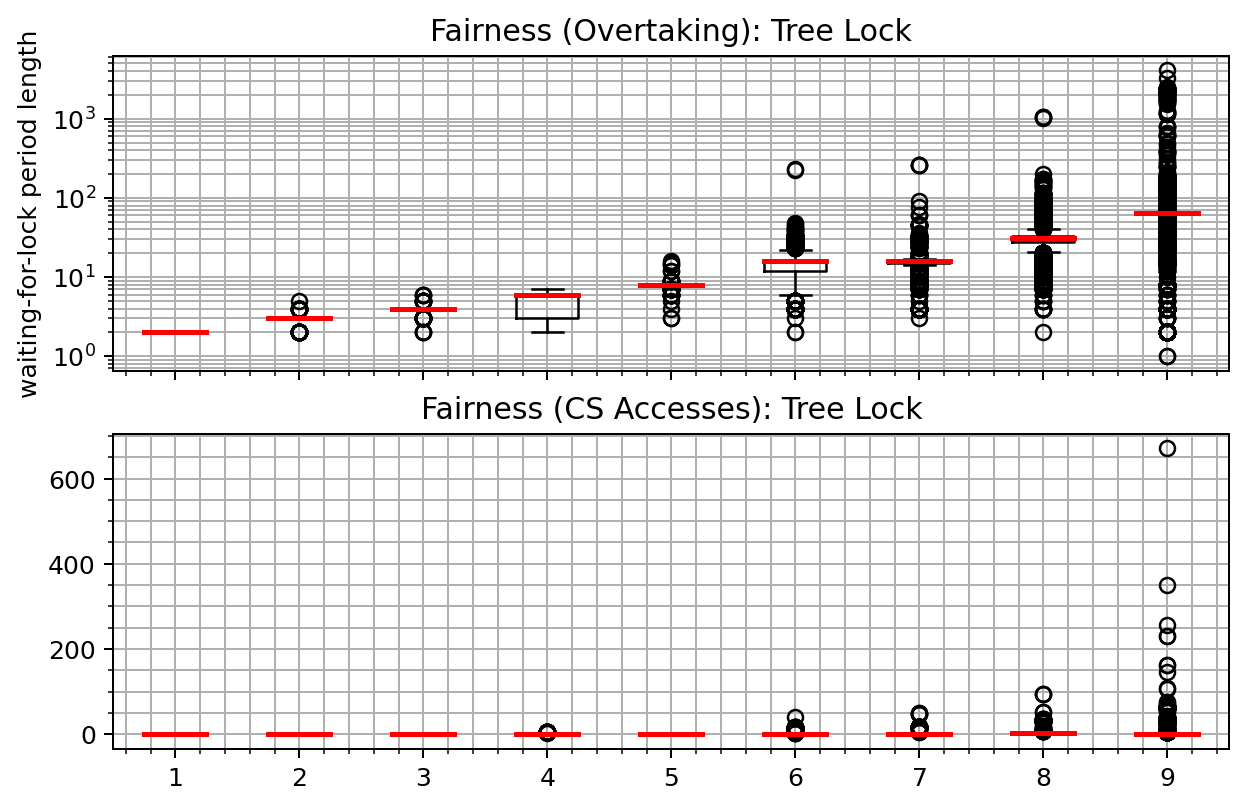

In [144]:
gaps_dict = dict(sorted(gaps_dict.items()))
freq_dict = dict(sorted(freq_dict.items()))


fig, ax = plt.subplots(2,1,sharex=True,figsize=(8,5), dpi=180)
ax[0].set_title("Fairness (Overtaking): " + lock_dict[which_lock] + " Lock")
ax[0].boxplot(gaps_dict.values(), medianprops={'color': 'red', 'linewidth': 2})
ax[0].set_yscale("log")
ax[0].minorticks_on()
ax[0].grid(which="both")
ax[0].set_xticklabels(gaps_dict.keys())
ax[0].set_ylabel("waiting-for-lock period length")

ax[1].set_title("Fairness (CS Accesses): " + lock_dict[which_lock] + " Lock")
ax[1].boxplot(freq_dict.values(), medianprops={'color': 'red', 'linewidth': 2})
ax[1].minorticks_on()
ax[1].grid(which="both")
# ax[1].set_xticklabels(freq_dict.keys())
ax[1].set_ylabel("deviation from fair lock distribution")


plt.xlabel("number of threads")
plt.tight_layout()
plt.savefig("./plots/" + "F_" + lock_dict[which_lock] + ".png", )

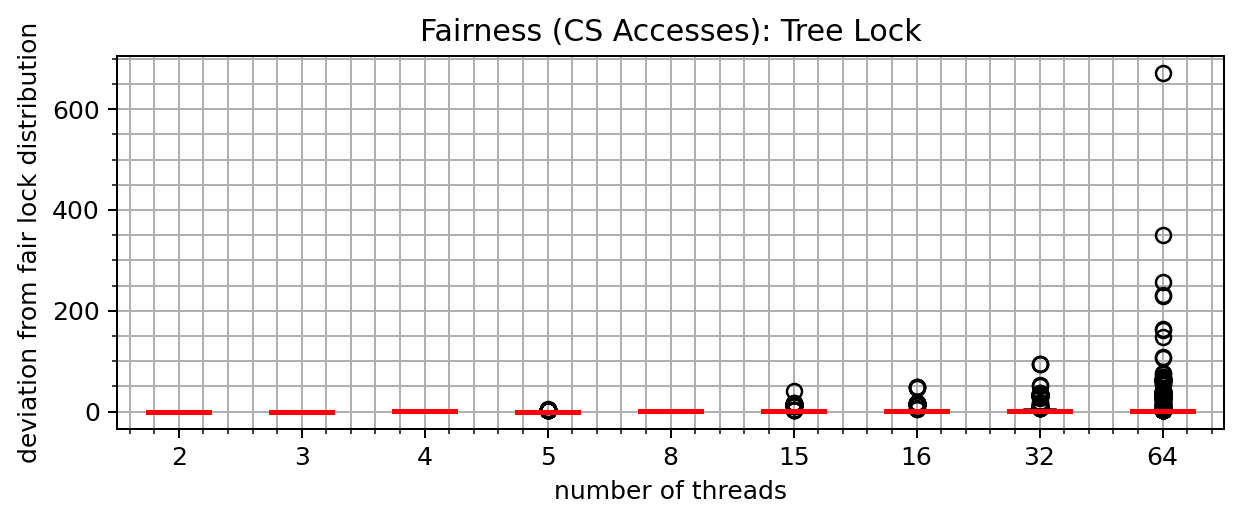

In [145]:
freq_dict = dict(sorted(freq_dict.items()))

fig, ax = plt.subplots(figsize=(7,3), dpi=180)
ax.set_title("Fairness (CS Accesses): " + lock_dict[which_lock] + " Lock")
ax.boxplot(freq_dict.values(), medianprops={'color': 'red', 'linewidth': 2})
ax.minorticks_on()
ax.grid(which="both")
ax.set_xticklabels(freq_dict.keys())
ax.set_xlabel("number of threads")
ax.set_ylabel("deviation from fair lock distribution")

plt.tight_layout()
plt.savefig("./plots/" + "F2_" + lock_dict[which_lock] + ".png")

In [131]:
# Path to output files and list of output files
TP_or_LAT = "TP"
cwd = os.getcwd()
data_src = glob.glob(cwd + path + "/" + TP_or_LAT + "_*")
file_names = [file_name.split('/')[-1] for file_name in data_src]

# Assign lock name to number according to convention
lock_dict = {1: 'OMP', 2: 'Filter', 3: 'Block-Woo', 4: 'Tree', 5: 'Alagarsamy'}

avg_dict = {}
std_dict = {}

which_lock = -1

for file in file_names:
    # Load one output file
    data = np.loadtxt(os.path.join(cwd + path, file), dtype=float)

    # Extract metadata from filename and data shape
    numbers = re.findall(r'\d+', file)
    n_threads = int(numbers[0])
    which_lock = int(numbers[1])
    n_locks = n_threads * n_threads
    total_runs = data.shape[0]

    # Compute the fairness metrics
    avg, std = data.mean(), data.std()

    avg_dict[n_threads] = avg
    std_dict[n_threads] = std

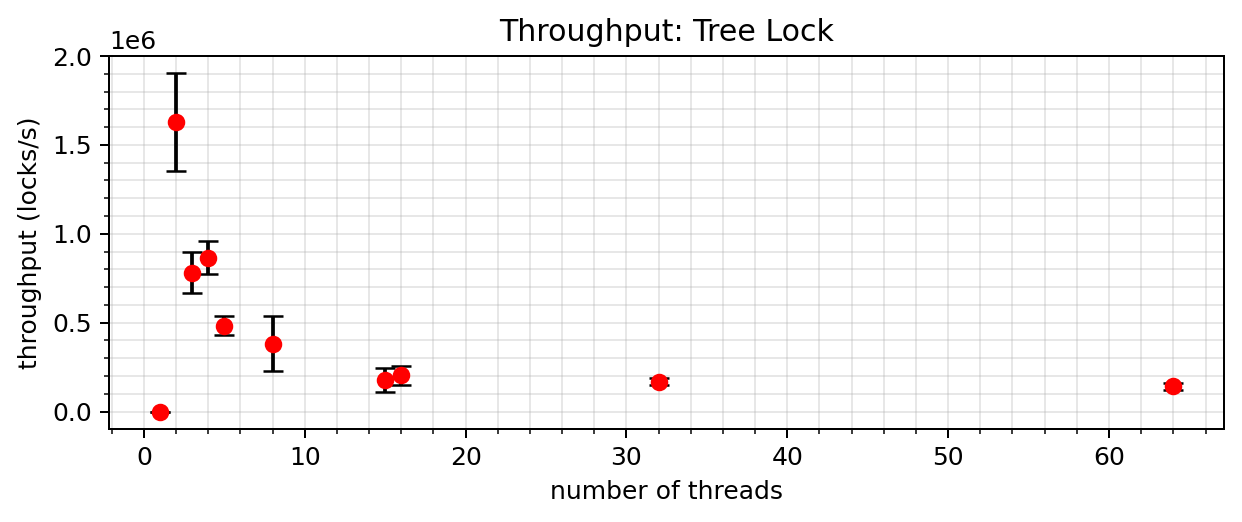

In [132]:
# Extract keys and values from the dictionaries
keys = list(avg_dict.keys())
values = list(avg_dict.values())
errors = list(std_dict.values())

plt.figure(figsize=(7, 3), dpi=180)

# Plot the data with error bars
plt.errorbar(keys, values, yerr=errors, fmt='o', capsize=4, color= 'red', ecolor='black')

if TP_or_LAT == "TP":
    plt.title("Throughput: " + lock_dict[which_lock] + " Lock")
elif TP_or_LAT == "LAT":
    plt.title("Latency: " + lock_dict[which_lock] + " Lock")

# Set labels for the x-axis and y-axis
plt.xlabel('number of threads')

if TP_or_LAT == "TP":
    plt.ylabel('throughput (locks/s)')
elif TP_or_LAT == "LAT":
    plt.ylabel('latency (microseconds)')

plt.minorticks_on()
plt.grid(which="both", alpha=0.3)
    
plt.tight_layout()
plt.savefig("./plots/" + TP_or_LAT + "_" + lock_dict[which_lock] + ".png")

# Show the plot
plt.show()

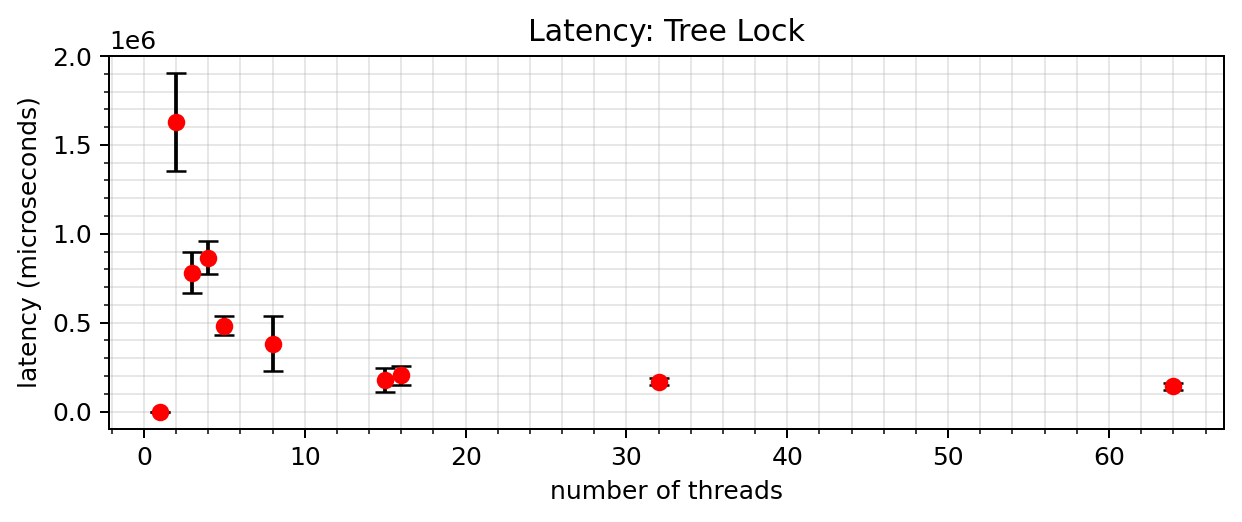

In [133]:
TP_or_LAT = "LAT"

# Extract keys and values from the dictionaries
keys = list(avg_dict.keys())
values = list(avg_dict.values())
errors = list(std_dict.values())

plt.figure(figsize=(7, 3), dpi=180)

# Plot the data with error bars
plt.errorbar(keys, values, yerr=errors, fmt='o', capsize=4, color= 'red', ecolor='black')

if TP_or_LAT == "TP":
    plt.title("Throughput: " + lock_dict[which_lock] + " Lock")
elif TP_or_LAT == "LAT":
    plt.title("Latency: " + lock_dict[which_lock] + " Lock")

# Set labels for the x-axis and y-axis
plt.xlabel('number of threads')

if TP_or_LAT == "TP":
    plt.ylabel('throughput (locks/s)')
elif TP_or_LAT == "LAT":
    plt.ylabel('latency (microseconds)')

plt.minorticks_on()
plt.grid(which="both", alpha=0.3)
    
plt.tight_layout()
plt.savefig("./plots/" + TP_or_LAT + "_" + lock_dict[which_lock] + ".png")

# Show the plot
plt.show()